In [1]:
from __future__ import absolute_import, division, print_function
import numpy as np
import os
import sys
sys.path.append(os.path.abspath('./'))
import casimir.data.named_entity_recognition as ner
import casimir.optim as optim 

In [2]:
train_file = 'data/ner/eng.train'
dev_file = 'data/ner/eng.testa'
test_file = 'data/ner/eng.testb'

assert os.path.isfile(train_file), 'train_file {} does not exist'.format(train_file)
assert os.path.isfile(dev_file), 'dev_file {} does not exist'.format(dev_file)
assert os.path.isfile(test_file), 'test_file {} does not exist'.format(test_file)

In [3]:
l2_list = [0.01,0.1,1.0]
model_list, logs_list=[],[]
for i in [0,1,2]:
    train_ifo, dev_ifo, test_ifo = ner.create_ner_ifo_from_data(train_file, dev_file, test_file,
                                                                smoothing_coefficient=10.0, num_highest_scores=5)
    l2reg = l2_list[i] / len(train_ifo)
    print('l2reg:', l2reg)
    l2penalty = optim.L2Penalty(l2reg)

    dim = 2**16 - 1  # hard-coded. All features are hashed onto these dimensions.
    model = np.zeros(dim)

    # Casimir-SVRG, decaying smoothing
    optim_options_2 = {'learning_rate': 2e-2, 'initial_smoothing_coefficient': 2.0, 'initial_moreau_coefficient': l2reg,
                       'warm_start': 'extrapolation'}

    # Run optimization
    num_passes = 30
    model, logs = optim.optimize_ifo(model, train_ifo, algorithm='casimir_svrg', dev_ifo=dev_ifo, test_ifo=None,
                                     reg_penalties=[l2penalty], num_passes=num_passes, termination_criterion=None, seed=25,
                                     logging=True, verbose=True,
                                     optim_options=optim_options_2)
    model_list.append(model)
    logs_list.append(logs)

l2reg: 7.121999857560003e-07
Epoch		Function		Dev_function	Dev_evaluation		Time
0.00		14.50188733		15.803692		0.019034		75.71


/home/runtian/anaconda3/envs/casimir/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


1.00		4.44309884		5.097533		0.622644		293.49
2.00		2.84461883		3.275635		0.711020		263.15
3.00		2.43963773		2.971398		0.729340		267.61
4.00		1.94248775		2.545161		0.746461		261.27
5.00		1.67289893		2.377142		0.757091		279.78
6.00		1.49490096		2.277061		0.763058		297.56
7.00		1.38631037		2.230042		0.765572		306.38
8.00		1.31610859		2.206731		0.769560		317.53
9.00		1.26823517		2.196153		0.772530		317.73
10.00		1.23300816		2.190549		0.773990		325.11
11.00		1.20555199		2.191879		0.772800		320.76
12.00		1.18334107		2.194837		0.773677		344.74
13.00		1.16352196		2.197541		0.774400		345.35
14.00		1.14769142		2.204205		0.774583		369.49
15.00		1.13296083		2.211853		0.775069		332.50
16.00		1.12010124		2.219745		0.777179		310.40
17.00		1.10831126		2.225720		0.777262		297.49
18.00		1.09781167		2.233091		0.777749		282.54
19.00		1.08893829		2.241285		0.775686		291.79
20.00		1.08051630		2.249534		0.775295		265.31
21.00		1.07217179		2.255989		0.774733		281.55
22.00		1.06450696		2.264801		0.774670		276.

In [4]:
import pickle as pkl
pkl.dump( model_list, open( "data/models/e3.model", "wb" ) )
pkl.dump( logs_list, open( "data/logs/e3.log", "wb" ) )

In [15]:
import matplotlib
import matplotlib.pyplot as plt
l2_list = [0.01,0.1,1.0]
logs_array = np.array(logs_list)
logs_array = logs_array[:,3:,:]
iteration = logs_array[0,:,0]

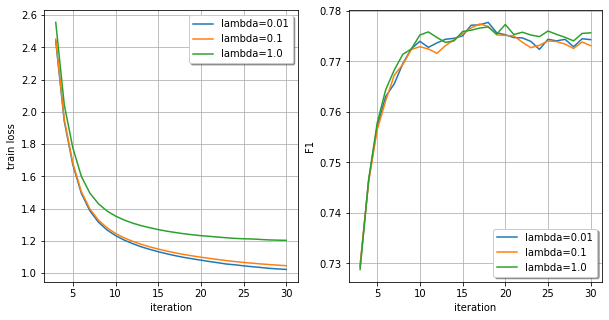

In [16]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
for i in [0,1,2]:
    plt.plot(iteration, logs_array[i,:,1], label='lambda='+str(l2_list[i]))
plt.xlabel('iteration')
plt.ylabel('train loss')
plt.grid()
plt.legend(loc='upper right', shadow=True)

plt.subplot(1,2,2)
for i in [0,1,2]:
    plt.plot(iteration, logs_array[i,:,3], label='lambda='+str(l2_list[i]))
plt.xlabel('iteration')
plt.ylabel('F1')
plt.grid()
plt.legend(loc='lower right', shadow=True)
plt.show()